# Diferentes Análises dos Dados (descritiva, exploratória & correlação)

Este notebook Jupyter contém os scripts Python utilizados para a **limpeza, pré-processamento, carga e análises (descritiva, exploratória & correlação) dos dados** dos Censos da Educação (Básica e Superior) do INEP, e dos microdados da PNAD Contínua do IBGE. O objetivo é preparar e integrar esses dados para investigar as correlações entre indicadores educacionais e socioeconômicos nos estados brasileiros.

---

## Estrutura do Notebook

O notebook está dividido em seções que representam as principais etapas do fluxo de trabalho:

1.  **Instalação e Importação de Bibliotecas**: Garante que todas as dependências necessárias estejam instaladas e carregadas.
2.  **Pré-processamento dos Dados do Censo Escolar (Educação Básica)**:
    * Leitura do arquivo `.csv` original, que é bastante extenso.
    * Seleção das colunas de interesse, conforme o dicionário de dados do projeto.
    * Criação de um novo arquivo `.csv` "limpo" e mais leve, contendo apenas as colunas relevantes.
    * Este passo é crucial para otimizar o desempenho na fase de carga no banco de dados.
3.  **Pré-processamento dos Dados do Censo da Educação Superior (IES)**:
    * Processo similar ao do Censo Escolar, com leitura do arquivo `.csv` original.
    * Seleção das colunas específicas para o Censo Superior.
    * Criação de um arquivo `.csv` "limpo" para as IES.
4.  **Conexão ao Banco de Dados PostgreSQL**:
    * Configuração dos parâmetros de conexão (host, database, usuário, senha).
    * Estabelecimento da conexão com o banco de dados PostgreSQL, onde os dados serão carregados para consultas SQL.
5.  **Análise Descritiva dos Dados (SQL e Pandas)**:
    * Execução de consultas SQL diretamente no PostgreSQL para obter estatísticas básicas e a distribuição dos dados de cada tabela (`escolas`, `ies`, `pnad`).
    * Visualização dos resultados usando DataFrames do Pandas e gráficos (barras, pizza) com Matplotlib/Seaborn para uma compreensão inicial do conjunto de dados. Exemplos incluem:
        * Número total de escolas e IES.
        * Distribuição geográfica das escolas e IES por estado.
        * Proporção de escolas por dependência administrativa (pública/privada).
        * Percentual de escolas com infraestrutura chave (internet, laboratórios, biblioteca).
        * Qualidade do corpo docente em IES (proporção de doutores).
        * Perfil demográfico da amostra da PNAD (sexo, idade, raça/cor).
        * Distribuição da população adulta por nível de instrução.
        * Proporção da amostra por situação no mercado de trabalho (ocupado, desocupado, etc.).
        * Média da renda bruta mensal.
    * **Tratamento de Outliers**: Uma consulta específica é utilizada para identificar as "Top 20" maiores escolas em número de alunos, permitindo uma análise sobre a presença de possíveis *outliers* nos dados e a discussão de sua relevância para o estudo.
6.  **Integração e Análise de Correlação (SQL e Pandas)**:
    * Nesta etapa, o foco é unir as diferentes fontes de dados para realizar a análise central do trabalho.
    * Consultas SQL são elaboradas para agregar os dados em nível de Unidade da Federação (UF), calculando indicadores-chave como:
        * Renda média e taxa de desocupação (PNAD, para população 25+).
        * Proporção da população com ensino superior (PNAD, para população 25+).
        * Percentual de escolas com internet e laboratórios (Censo Escolar).
        * Proporção de docentes com doutorado em IES (Censo Superior).
    * Os resultados dessas consultas são carregados em DataFrames do Pandas e, em seguida, unificados em um único DataFrame por UF.
    * A **matriz de correlação** entre esses indicadores é calculada e visualizada através de um heatmap (mapa de calor) utilizando a biblioteca Seaborn. Este heatmap permite identificar visualmente as relações e forças de correlação entre as variáveis educacionais e os indicadores de emprego/renda.

---

**Observação**: Os caminhos dos arquivos e as credenciais do banco de dados estão configurados para um ambiente específico (mencionado no código). É importante **modificá-los** para usar em um outro ambiente antes de executar as células.a o seu ambiente antes de executar as células.

In [2]:
!pip install pandas

  Using cached pandas-2.3.0-cp313-cp313-macosx_10_13_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.0-cp313-cp313-macosx_10_13_x86_64.whl (11.5 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


In [ ]:
import pandas as pd
import os

# --- ATENÇÃO: MODIFIQUE OS CAMINHOS AQUI ---
# Coloque o caminho completo para o seu arquivo CSV original e pesado.
caminho_arquivo_original = r'/Users/felipedamasceno/Downloads/tp2/microdados_censo_escolar_2023/dados/microdados_ed_basica_2023.csv'

# Defina onde você quer salvar o novo arquivo, mais leve e limpo.
caminho_arquivo_limpo = r'/Users/felipedamasceno/Downloads/tp2/microdados_censo_escolar_2023/dados/escola_limpo.csv'
# ----------------------------------------------

# Lista das 25 colunas que você quer manter (exatamente como na sua tabela SQL).
colunas_para_manter = [
    'NU_ANO_CENSO', 'SG_UF', 'NO_UF', 'CO_MUNICIPIO', 'NO_MUNICIPIO', 'CO_ENTIDADE',
    'NO_ENTIDADE', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'IN_AGUA_POTAVEL',
    'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_LIXO_SERVICO_COLETA',
    'IN_BIBLIOTECA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_QUADRA_ESPORTES', 'IN_SALA_ATENDIMENTO_ESPECIAL', 'IN_INTERNET',
    'IN_BANDA_LARGA', 'QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS',
    'QT_MAT_BAS', 'QT_MAT_FUND', 'QT_MAT_MED'
]

print("Iniciando a leitura do arquivo original. Isso pode levar alguns minutos...")

# Lê o CSV original, mantendo todos os dados como texto para evitar erros.
# Usamos os mesmos parâmetros que descobrimos antes.
df = pd.read_csv(
    caminho_arquivo_original,
    delimiter=';',
    encoding='latin1',
    usecols=colunas_para_manter, # Otimização: lê apenas as colunas que precisamos
    dtype=str  # Lê todas as colunas como string para evitar problemas de tipo de dado
)

print("Arquivo original lido com sucesso!")
print(f"O arquivo tem {len(df)} linhas.")

# Salva um NOVO arquivo CSV contendo apenas as colunas selecionadas.
df.to_csv(
    caminho_arquivo_limpo,
    index=False,      # Muito importante para não salvar o índice do pandas no arquivo
    sep=';',          # Usa o mesmo delimitador
    encoding='latin1' # Usa a mesma codificação
)

print("-" * 50)
print("PROCESSO CONCLUÍDO!")
print(f"Novo arquivo limpo foi salvo em: {caminho_arquivo_limpo}")

Iniciando a leitura do arquivo original. Isso pode levar alguns minutos...
Arquivo original lido com sucesso!
O arquivo tem 217625 linhas.
--------------------------------------------------
PROCESSO CONCLUÍDO!
Novo arquivo limpo foi salvo em: /Users/felipedamasceno/Downloads/tp2/microdados_censo_escolar_2023/dados/escola_limpo.csv


In [5]:
import pandas as pd
import os

# --- ATENÇÃO: MODIFIQUE OS CAMINHOS AQUI ---
# Coloque o caminho completo para o seu arquivo CSV do Censo Superior.
caminho_arquivo_original_sup = r'/Users/felipedamasceno/Downloads/tp2/microdados_censo_da_educacao_superior_2023/dados/MICRODADOS_ED_SUP_IES_2023.CSV'

# Defina onde você quer salvar o novo arquivo, mais leve e limpo.
caminho_arquivo_limpo_sup = r'/Users/felipedamasceno/Downloads/tp2/microdados_censo_da_educacao_superior_2023/dados/MICRODADOS_ED_SUP_IES_2023_limpo.CSV'
# ----------------------------------------------

# Lista das colunas que você quer manter (exatamente como na sua tabela SQL 'ies').
colunas_para_manter_superior = [
    'CO_IES',
    'NO_IES',
    'SG_IES',
    'SG_UF_IES',
    'NO_MUNICIPIO_IES',
    'CO_MUNICIPIO_IES',
    'TP_ORGANIZACAO_ACADEMICA',
    'TP_REDE',
    'TP_CATEGORIA_ADMINISTRATIVA',
    'QT_DOC_EXE',
    'QT_DOC_EX_DOUT',
    'QT_DOC_EX_MEST',
    'QT_DOC_EX_INT_DE',
    'IN_ACESSO_PORTAL_CAPES',
    'IN_REPOSITORIO_INSTITUCIONAL'
]

print("Iniciando a leitura do arquivo do Censo Superior. Isso pode levar um momento...")

# Lê o CSV original do Censo Superior
df_sup = pd.read_csv(
    caminho_arquivo_original_sup,
    delimiter=';',
    encoding='latin1',
    usecols=colunas_para_manter_superior, # Otimização para ler apenas as colunas de interesse
    dtype=str  # Lê tudo como texto para máxima compatibilidade
)

print("Arquivo original lido com sucesso!")
print(f"Foram encontradas {len(df_sup)} instituições de ensino superior.")

# Salva o novo arquivo CSV limpo.
df_sup.to_csv(
    caminho_arquivo_limpo_sup,
    index=False,
    sep=';',
    encoding='latin1'
)

print("-" * 50)
print("PROCESSO CONCLUÍDO!")
print(f"Novo arquivo limpo para IES foi salvo em: {caminho_arquivo_limpo_sup}")

Iniciando a leitura do arquivo do Censo Superior. Isso pode levar um momento...
Arquivo original lido com sucesso!
Foram encontradas 2580 instituições de ensino superior.
--------------------------------------------------
PROCESSO CONCLUÍDO!
Novo arquivo limpo para IES foi salvo em: /Users/felipedamasceno/Downloads/tp2/microdados_censo_da_educacao_superior_2023/dados/MICRODADOS_ED_SUP_IES_2023_limpo.CSV


In [10]:
!pip install matplotlib seaborn

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_10_13_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_x86_64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_10_13_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_10_13_x86_64.whl (8.2 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_10_13_x86_64.whl (271 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_x86_64.whl (2.3 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_10_13_x86_64.whl (66 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


In [86]:
# Importa as bibliotecas necessárias
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# --- ATENÇÃO: MODIFIQUE ESTES VALORES ---
conn_params = {
    "host": "localhost",
    "dbname": "tp2",  # O nome do seu banco de dados
    "user": "postgres",       # Seu usuário do PostgreSQL
    "password": "euamoogalo"   # Sua senha do PostgreSQL
}
# -----------------------------------------

# Estabelece a conexão
try:
    conn = psycopg2.connect(**conn_params)
    print("Conexão com o PostgreSQL bem-sucedida!")
except Exception as e:
    print(f"Erro ao conectar ao banco de dados: {e}")
    conn = None # Garante que a conexão não será usada se falhar

# Configura o pandas para mostrar mais linhas se necessário
pd.set_option('display.max_rows', 100)

Conexão com o PostgreSQL bem-sucedida!


In [ ]:
if conn:
    # Define a consulta SQL
    query_total = "SELECT COUNT(*) AS total_de_escolas FROM escolas;"
    
    # Executa a consulta e carrega o resultado em um DataFrame do pandas
    df_total = pd.read_sql_query(query_total, conn)
    
    # Mostra o resultado
    print(df_total)

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/3375987242.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_total = pd.read_sql_query(query_total, conn)


   total_de_escolas
0            217625


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/370234406.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo = pd.read_sql_query(query_geo, conn)


Distribuição de Escolas por Estado:
   sg_uf  numero_de_escolas
0     SP              34099
1     MG              24293
2     BA              19611
3     MA              13635
4     RJ              13229
5     PA              12092
6     RS              11287
7     CE              10648
8     PE              10219
9     PR               9999
10    SC               7376
11    AM               6148
12    PI               5849
13    PB               5479
14    GO               5047
15    RN               4867
16    ES               4037
17    AL               3473
18    MT               3154
19    SE               2567
20    TO               2293
21    MS               1939
22    AC               1658
23    RO               1416
24    DF               1319
25    AP                950
26    RR                941

Gráfico dos 10 Estados com mais escolas:


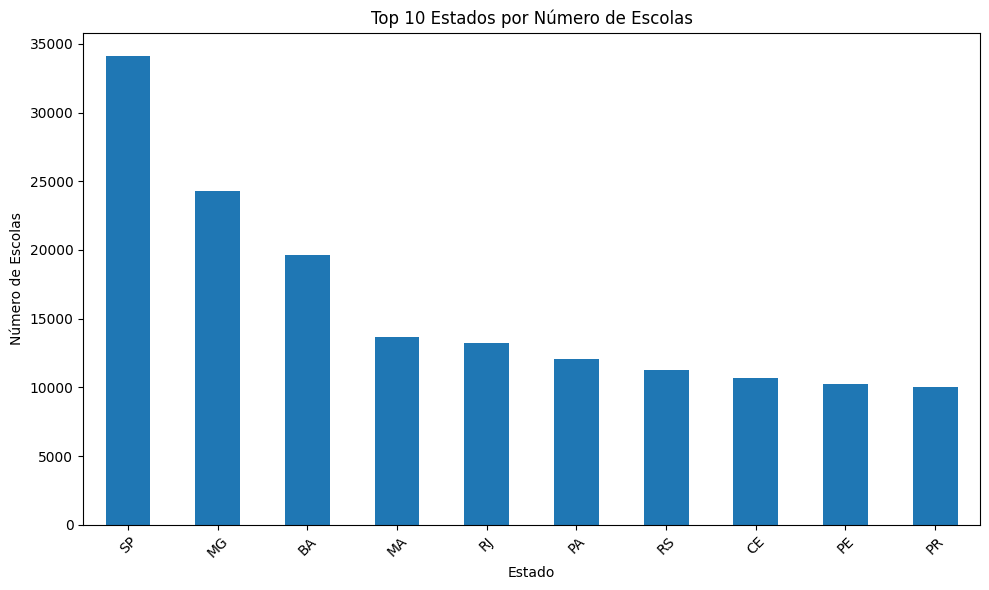

In [ ]:
if conn:
    query_geo = """
        SELECT
            SG_UF,
            COUNT(*) AS numero_de_escolas
        FROM
            escolas
        GROUP BY
            SG_UF
        ORDER BY
            numero_de_escolas DESC;
    """
    df_geo = pd.read_sql_query(query_geo, conn)
    
    print("Distribuição de Escolas por Estado:")
    print(df_geo)

    # Criando um gráfico de barras com os 10 estados com mais escolas
    print("\nGráfico dos 10 Estados com mais escolas:")
    df_geo.head(10).plot(kind='bar', x='sg_uf', y='numero_de_escolas',
                         title='Top 10 Estados por Número de Escolas',
                         xlabel='Estado', ylabel='Número de Escolas',
                         figsize=(10, 6), legend=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/1519333090.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dep = pd.read_sql_query(query_dep, conn)


Distribuição por Dependência Administrativa:
  dependencia_administrativa  numero_de_escolas
0          Pública Municipal             130709
1                    Privada              52645
2           Pública Estadual              33546
3            Pública Federal                725

Gráfico de Proporção por Dependência:


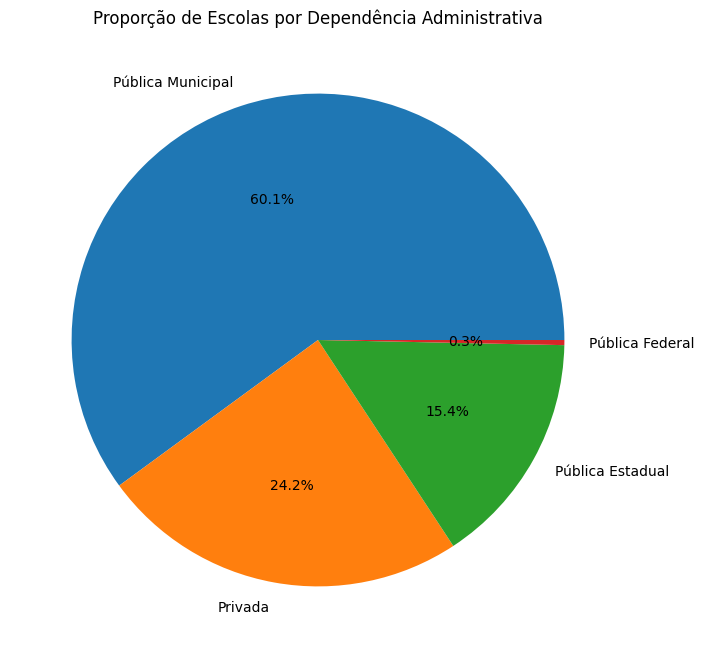

In [15]:
if conn:
    query_dep = """
        SELECT
            CASE
                WHEN TP_DEPENDENCIA = 1 THEN 'Pública Federal'
                WHEN TP_DEPENDENCIA = 2 THEN 'Pública Estadual'
                WHEN TP_DEPENDENCIA = 3 THEN 'Pública Municipal'
                WHEN TP_DEPENDENCIA = 4 THEN 'Privada'
            END AS dependencia_administrativa,
            COUNT(*) AS numero_de_escolas
        FROM
            escolas
        GROUP BY
            dependencia_administrativa
        ORDER BY
            numero_de_escolas DESC;
    """
    df_dep = pd.read_sql_query(query_dep, conn)
    
    print("Distribuição por Dependência Administrativa:")
    print(df_dep)

    # Criando um gráfico de pizza para visualizar a proporção
    print("\nGráfico de Proporção por Dependência:")
    df_dep.plot(kind='pie', y='numero_de_escolas', labels=df_dep['dependencia_administrativa'],
                autopct='%1.1f%%',  # Formato da porcentagem
                figsize=(8, 8), title='Proporção de Escolas por Dependência Administrativa',
                legend=False)
    plt.ylabel('') # Remove o label 'numero_de_escolas' do eixo y
    plt.show()

In [22]:
if conn:
    query_infra = """
        SELECT
            ROUND(AVG(IN_BIBLIOTECA) * 100, 2) AS perc_com_biblioteca,
            ROUND(AVG(IN_LABORATORIO_CIENCIAS) * 100, 2) AS perc_com_lab_ciencias,
            ROUND(AVG(IN_LABORATORIO_INFORMATICA) * 100, 2) AS perc_com_lab_informatica,
            ROUND(AVG(IN_INTERNET) * 100, 2) AS perc_com_internet,
            ROUND(AVG(IN_BANDA_LARGA) * 100, 2) AS perc_com_banda_larga
        FROM
            escolas;
    """
    df_infra = pd.read_sql_query(query_infra, conn)
    
    print("Percentual de Escolas com Infraestrutura Chave (Nacional):")
    # A função .T transpõe a tabela para uma melhor visualização
    print(df_infra.T)

Percentual de Escolas com Infraestrutura Chave (Nacional):
                              0
perc_com_biblioteca       36.55
perc_com_lab_ciencias     12.55
perc_com_lab_informatica  30.22
perc_com_internet         90.91
perc_com_banda_larga      86.67


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/654380528.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_infra = pd.read_sql_query(query_infra, conn)


In [24]:
if conn:
    query_local = """
        SELECT
            CASE
                WHEN TP_LOCALIZACAO = 1 THEN 'Urbana'
                WHEN TP_LOCALIZACAO = 2 THEN 'Rural'
            END AS localizacao,
            COUNT(*) AS total_escolas,
            ROUND(AVG(IN_INTERNET) * 100, 2) AS perc_com_internet
        FROM
            escolas
        GROUP BY
            localizacao;
    """
    df_local = pd.read_sql_query(query_local, conn)
    
    print("Comparativo de Acesso à Internet (Urbana vs. Rural):")
    print(df_local)

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/300808622.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_local = pd.read_sql_query(query_local, conn)


Comparativo de Acesso à Internet (Urbana vs. Rural):
  localizacao  total_escolas  perc_com_internet
0       Rural          73463              72.63
1      Urbana         144162              98.31


In [30]:
if conn:
  query_outliers = """
    SELECT
      NO_ENTIDADE,
      NO_MUNICIPIO,
      SG_UF,
      QT_MAT_BAS
    FROM
      escolas
    WHERE
      QT_MAT_BAS IS NOT NULL
    ORDER BY
      QT_MAT_BAS DESC
    LIMIT 20;
  """
  df_outliers = pd.read_sql_query(query_outliers, conn)
  
  print("Top 20 Maiores Escolas por Número de Alunos:")
  print(df_outliers)

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/3817373099.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_outliers = pd.read_sql_query(query_outliers, conn)


Top 20 Maiores Escolas por Número de Alunos:
                                          no_entidade    no_municipio sg_uf  \
0                              INSTITUTO MONITOR LTDA       São Paulo    SP   
1                             SENAC RIO GRANDE DO SUL    Porto Alegre    RS   
2   ESCOLA TECNICA ESTADUAL PROFESSOR ANTONIO CARL...          Recife    PE   
3   INSTITUTO BRASILEIRO DE EDUCACAO PROFISSIONAL ...       São Paulo    SP   
4     CENTRO DE PROFISSIONALIZACAO E EDUCACAO TECNICA         Mossoró    RN   
5     INSTITUTO BRASILEIRO DE ED PROFISSIONAL - IBREP   Florianópolis    SC   
6   UNIDADE SESI DE ENSINO MEDIO FRANSCISCO XAVIER...   Novo Hamburgo    RS   
7                                 UNIDADE SESI RETIRO        Salvador    BA   
8                              INSTITUTO MONITOR LTDA  Rio de Janeiro    RJ   
9                  INSTITUTO EDUCACIONAL MONITOR LTDA        Curitiba    PR   
10            GRUPO DE ESTUDO DE EDUCACAO A DISTANCIA       São Paulo    SP   
11     

In [31]:
# Verifica se a conexão está ativa antes de executar
if conn:
    # Conta o número total de IES na tabela.
    query_total_ies = "SELECT COUNT(*) AS total_de_ies FROM ies;"
    
    df_total_ies = pd.read_sql_query(query_total_ies, conn)
    
    print(df_total_ies)

   total_de_ies
0          2580


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/3367404767.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_total_ies = pd.read_sql_query(query_total_ies, conn)


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/14727018.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo_ies = pd.read_sql_query(query_geo_ies, conn)


Distribuição de IES por Estado:
  sg_uf_ies  numero_de_ies
0        SP            586
1        MG            310
2        PR            174
3        BA            149
4        RJ            128

Gráfico dos 10 Estados com mais IES:


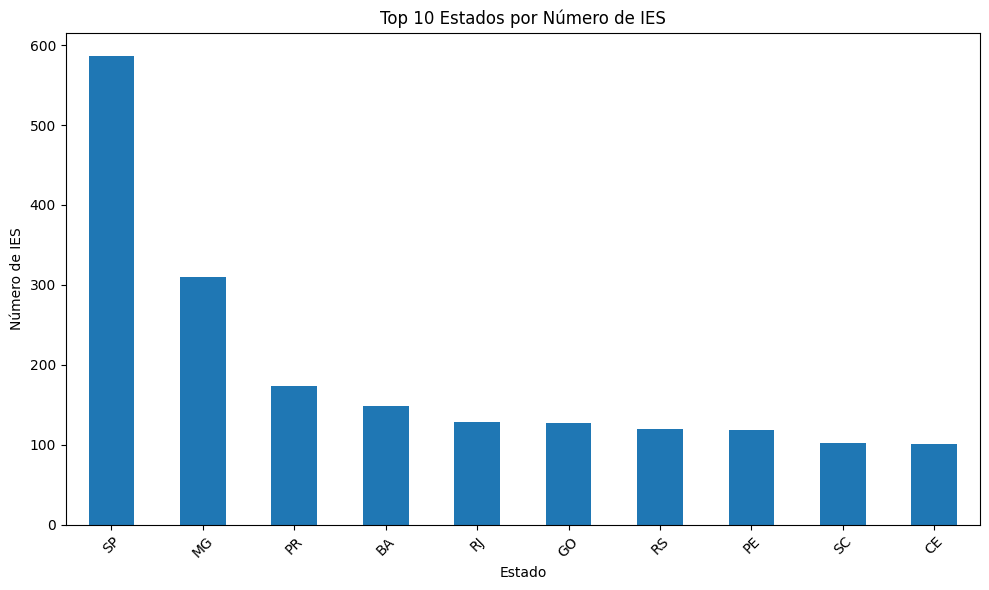

In [32]:
if conn:
    query_geo_ies = """
        SELECT
            SG_UF_IES,
            COUNT(*) AS numero_de_ies
        FROM
            ies
        GROUP BY
            SG_UF_IES
        ORDER BY
            numero_de_ies DESC;
    """
    df_geo_ies = pd.read_sql_query(query_geo_ies, conn)
    
    print("Distribuição de IES por Estado:")
    print(df_geo_ies.head())

    # Criando um gráfico de barras com os 10 estados com mais IES
    print("\nGráfico dos 10 Estados com mais IES:")
    df_geo_ies.head(10).plot(kind='bar', x='sg_uf_ies', y='numero_de_ies',
                             title='Top 10 Estados por Número de IES',
                             xlabel='Estado', ylabel='Número de IES',
                             figsize=(10, 6), legend=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/2908847636.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rede_ies = pd.read_sql_query(query_rede_ies, conn)


Distribuição por Tipo de Rede:
  tipo_de_rede  quantidade_de_ies
0      Privada               2264
1      Pública                316

Gráfico de Proporção por Rede:


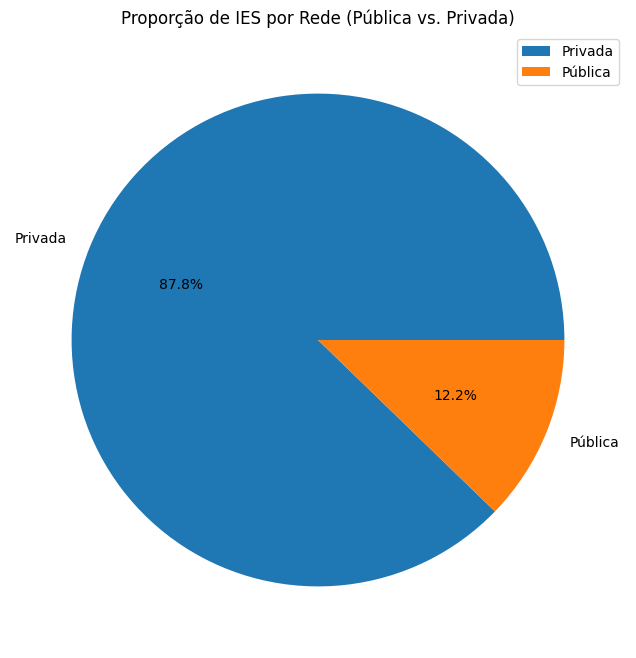

In [33]:
if conn:
    query_rede_ies = """
        SELECT
            CASE
                WHEN TP_REDE = 1 THEN 'Pública'
                WHEN TP_REDE = 2 THEN 'Privada'
            END AS tipo_de_rede,
            COUNT(*) AS quantidade_de_ies
        FROM
            ies
        GROUP BY
            tipo_de_rede;
    """
    df_rede_ies = pd.read_sql_query(query_rede_ies, conn)
    
    print("Distribuição por Tipo de Rede:")
    print(df_rede_ies)
    
    # Gráfico de pizza para mostrar a enorme diferença
    print("\nGráfico de Proporção por Rede:")
    df_rede_ies.plot(kind='pie', y='quantidade_de_ies', labels=df_rede_ies['tipo_de_rede'],
                     autopct='%1.1f%%', figsize=(8, 8), 
                     title='Proporção de IES por Rede (Pública vs. Privada)')
    plt.ylabel('')
    plt.show()

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/1939338293.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_qualidade_rede = pd.read_sql_query(query_qualidade_rede, conn)


Qualidade Média do Corpo Docente por Tipo de Rede:
  tipo_de_rede  avg_perc_doutores
0      Pública              48.35
1      Privada              28.27


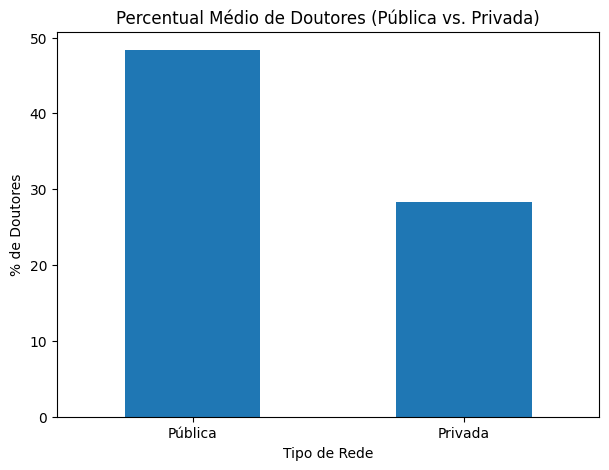

In [34]:
if conn:
    query_qualidade_rede = """
        SELECT
            CASE
                WHEN TP_REDE = 1 THEN 'Pública'
                WHEN TP_REDE = 2 THEN 'Privada'
            END AS tipo_de_rede,
            -- Calcula a média da proporção de doutores para cada tipo de rede
            ROUND(AVG((QT_DOC_EX_DOUT * 100.0) / NULLIF(QT_DOC_EXE, 0)), 2) AS avg_perc_doutores
        FROM
            ies
        WHERE
            QT_DOC_EXE > 0 -- Garante que estamos analisando IES com docentes
        GROUP BY
            tipo_de_rede
        ORDER BY
            avg_perc_doutores DESC;
    """
    df_qualidade_rede = pd.read_sql_query(query_qualidade_rede, conn)
    
    print("Qualidade Média do Corpo Docente por Tipo de Rede:")
    print(df_qualidade_rede)

    # Gráfico de barras para comparar
    df_qualidade_rede.plot(kind='bar', x='tipo_de_rede', y='avg_perc_doutores',
                           title='Percentual Médio de Doutores (Pública vs. Privada)',
                           xlabel='Tipo de Rede', ylabel='% de Doutores',
                           figsize=(7, 5), legend=False, rot=0)
    plt.show()

In [38]:
if conn:
    query_polos = """
        SELECT
            NO_MUNICIPIO_IES,
            SG_UF_IES,
            -- Usamos SUM para agregar os totais do município
            SUM(QT_DOC_EXE) as total_docentes_municipio,
            SUM(QT_DOC_EX_DOUT) as total_doutores_municipio,
            -- Calculamos a proporção geral de doutores para o município
            ROUND(SUM(QT_DOC_EX_DOUT) * 100.0 / SUM(QT_DOC_EXE), 2) AS perc_doutores_municipio
        FROM
            ies
        WHERE
            QT_DOC_EXE > 0
        GROUP BY
            NO_MUNICIPIO_IES, SG_UF_IES
        -- Filtramos para municípios com mais de 200 docentes para ter relevância
        HAVING
            SUM(QT_DOC_EXE) > 200
        ORDER BY
            perc_doutores_municipio DESC
        LIMIT 20;
    """
    df_polos = pd.read_sql_query(query_polos, conn)
    
    print("Top 20 Municípios por Qualidade do Corpo Docente:")
    print(df_polos)

Top 20 Municípios por Qualidade do Corpo Docente:
    no_municipio_ies sg_uf_ies  total_docentes_municipio  \
0           Redenção        CE                       384   
1         Ouro Preto        MG                       861   
2         Seropédica        RJ                      1272   
3         São Carlos        SP                      1617   
4         Rio Grande        RS                      1068   
5             Viçosa        MG                      1417   
6      São Cristóvão        SE                      1768   
7            Niterói        RJ                      3865   
8         Diamantina        MG                       937   
9             Lavras        MG                      1114   
10           Pelotas        RS                      2325   
11      Porto Alegre        RS                      5745   
12           Itajubá        MG                       715   
13       Santa Maria        RS                      3250   
14          Campinas        SP                    

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/3166466807.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_polos = pd.read_sql_query(query_polos, conn)


In [87]:
if conn:
    # CONSULTA CORRIGIDA: Adicionado CAST( ... AS NUMERIC)
    query_demografia = """
        SELECT
            CASE WHEN SEXO = 1 THEN 'Homem' ELSE 'Mulher' END AS sexo,
            CASE 
                WHEN COR_RACA = 1 THEN 'Branca'
                WHEN COR_RACA = 2 THEN 'Preta'
                WHEN COR_RACA = 3 THEN 'Amarela'
                WHEN COR_RACA = 4 THEN 'Parda'
                WHEN COR_RACA = 5 THEN 'Indígena'
                ELSE 'Não declarado'
            END AS cor_raca,
            COUNT(*) AS total_pessoas,
            ROUND(CAST(AVG(IDADE) AS NUMERIC), 1) AS idade_media
        FROM
            pnad
        GROUP BY
            sexo, cor_raca
        ORDER BY
            sexo, total_pessoas DESC;
    """
    df_demografia = pd.read_sql_query(query_demografia, conn)
    
    print("Perfil Demográfico da Amostra da PNAD:")
    print(df_demografia)

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/869175477.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_demografia = pd.read_sql_query(query_demografia, conn)


Perfil Demográfico da Amostra da PNAD:
      sexo       cor_raca  total_pessoas  idade_media
0    Homem          Parda         463188         34.4
1    Homem         Branca         354660         38.1
2    Homem          Preta          91890         38.4
3    Homem       Indígena           5030         33.5
4    Homem        Amarela           4852         40.3
5    Homem  Não declarado             92         43.6
6   Mulher          Parda         484151         36.1
7   Mulher         Branca         391908         40.6
8   Mulher          Preta          93298         40.1
9   Mulher        Amarela           5987         41.8
10  Mulher       Indígena           5808         35.5
11  Mulher  Não declarado            125         39.2


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/2095077991.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_educacao_adultos = pd.read_sql_query(query_educacao_adultos, conn)


Distribuição da População Adulta (25+ anos) por Nível de Instrução:
        nivel_instrucao_agrupado  total_pessoas
0  Não Aplicável / Sem Instrução         132172
1         Fundamental I ou Menos         164373
2                 Fundamental II         351185
3                          Médio         395112
4                       Superior         165867
5                  Pós-Graduação          57123


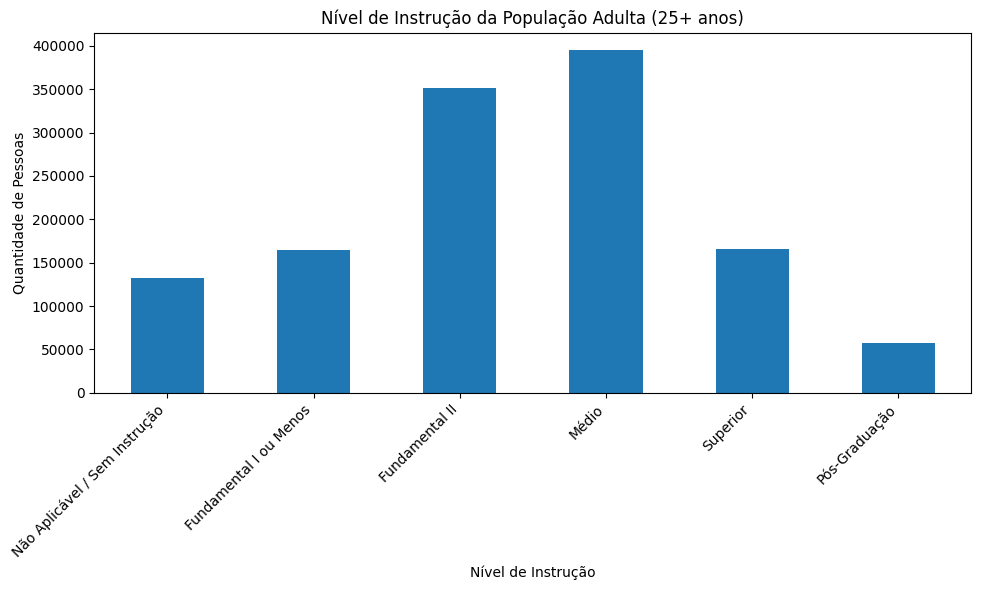

In [88]:
if conn:
    # CONSULTA FINAL E ROBUSTA: Usando uma CTE (cláusula WITH) para resolver o erro de agrupamento.
    query_educacao_adultos = """
        -- Passo 1: Cria uma tabela temporária chamada 'dados_agrupados' com a contagem por nível de instrução.
        WITH dados_agrupados AS (
            SELECT
                CASE 
                    WHEN CURSO_ELEVADO_ANTERIOR IN ('1', '2', '3', '4', '5') THEN 'Fundamental I ou Menos'
                    WHEN CURSO_ELEVADO_ANTERIOR IN ('6','7','8') THEN 'Fundamental II'
                    WHEN CURSO_ELEVADO_ANTERIOR IN ('9','10', '11') THEN 'Médio'
                    WHEN CURSO_ELEVADO_ANTERIOR = '12' THEN 'Superior'
                    WHEN CURSO_ELEVADO_ANTERIOR IN ('13','14','15') THEN 'Pós-Graduação'
                    ELSE 'Não Aplicável / Sem Instrução'
                END AS nivel_instrucao_agrupado,
                COUNT(*) as total_pessoas
            FROM
                pnad
            WHERE
                IDADE >= 25 -- Filtro para analisar apenas a população adulta
            GROUP BY
                nivel_instrucao_agrupado
        )
        -- Passo 2: Seleciona os dados da tabela temporária e aplica a ordenação correta.
        SELECT 
            * FROM 
            dados_agrupados
        ORDER BY
            CASE 
                WHEN nivel_instrucao_agrupado = 'Não Aplicável / Sem Instrução' THEN 0
                WHEN nivel_instrucao_agrupado = 'Fundamental I ou Menos' THEN 1
                WHEN nivel_instrucao_agrupado = 'Fundamental II' THEN 2
                WHEN nivel_instrucao_agrupado = 'Médio' THEN 3
                WHEN nivel_instrucao_agrupado = 'Superior' THEN 4
                WHEN nivel_instrucao_agrupado = 'Pós-Graduação' THEN 5
            END;
    """
    df_educacao_adultos = pd.read_sql_query(query_educacao_adultos, conn)
    
    print("Distribuição da População Adulta (25+ anos) por Nível de Instrução:")
    print(df_educacao_adultos)

    # O código do gráfico continua o mesmo e agora funcionará com os dados corretos e ordenados.
    df_educacao_adultos.plot(kind='bar', x='nivel_instrucao_agrupado', y='total_pessoas',
                             title='Nível de Instrução da População Adulta (25+ anos)',
                             xlabel='Nível de Instrução', ylabel='Quantidade de Pessoas',
                             figsize=(10, 6), legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/3348617432.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mercado_trabalho = pd.read_sql_query(query_mercado_trabalho, conn)


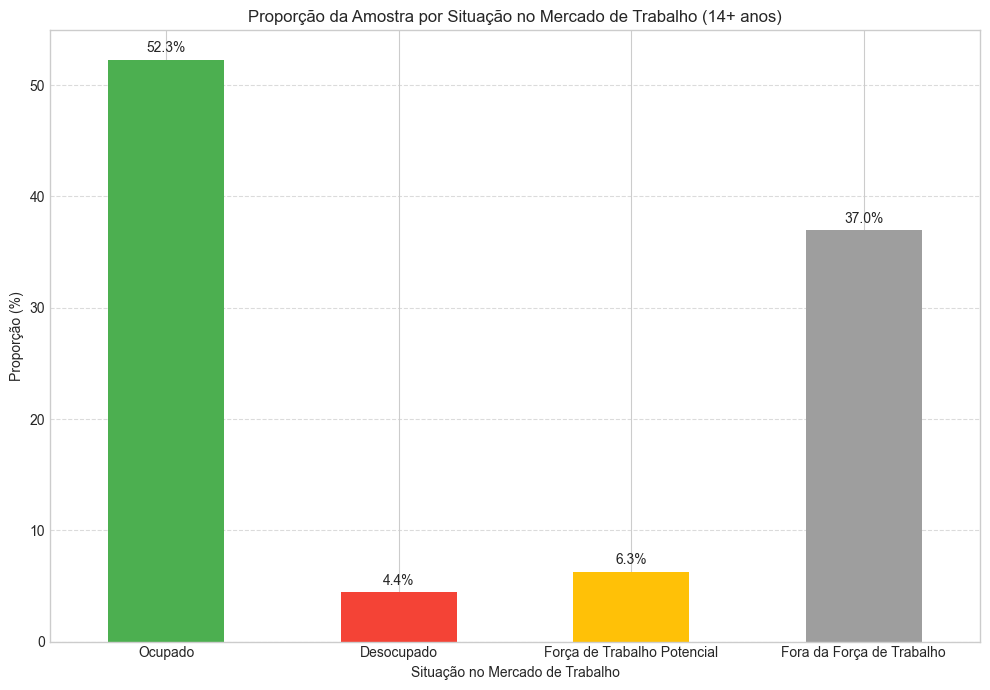

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Conecte-se ao banco de dados SQLite (ajuste o caminho conforme necessário)
# conn = sqlite3.connect('seu_banco_de_dados.db')

if conn:
    # Query: calcula a proporção da amostra por categoria (sem usar pesos)
    query_mercado_trabalho = """
        WITH dados_classificados AS (
            SELECT
                CASE
                    WHEN trab_remun_dinheiro = 1 OR
                         trab_remun_prod_merc = 1 OR
                         fez_bico_ocasional = 1 OR
                         ajuda_trab_nao_remun = 1 OR
                         afastado_trab_remun = 1
                    THEN 'Ocupado'
                    WHEN procurou_trabalho = 1
                    THEN 'Desocupado'
                    WHEN gostaria_trab_nao_procura = 1
                    THEN 'Força de Trabalho Potencial'
                    ELSE 'Fora da Força de Trabalho'
                END AS situacao_trabalho
            FROM
                pnad
            WHERE
                idade >= 14
        ),
        totais AS (
            SELECT
                situacao_trabalho,
                COUNT(*) AS quantidade
            FROM dados_classificados
            GROUP BY situacao_trabalho
        ),
        total_geral AS (
            SELECT SUM(quantidade) AS total_amostra FROM totais
        )
        SELECT
            t.situacao_trabalho,
            ROUND(1.0 * t.quantidade / tg.total_amostra, 4) AS proporcao
        FROM
            totais t, total_geral tg
        ORDER BY
            CASE
                WHEN t.situacao_trabalho = 'Ocupado' THEN 1
                WHEN t.situacao_trabalho = 'Desocupado' THEN 2
                WHEN t.situacao_trabalho = 'Força de Trabalho Potencial' THEN 3
                WHEN t.situacao_trabalho = 'Fora da Força de Trabalho' THEN 4
            END;
    """

    # Executa a query
    df_mercado_trabalho = pd.read_sql_query(query_mercado_trabalho, conn)

    # Converte proporção para percentual
    df_mercado_trabalho['proporcao'] *= 100

    # Gráfico de barras
    ax = df_mercado_trabalho.plot(
        kind='bar',
        x='situacao_trabalho',
        y='proporcao',
        title='Proporção da Amostra por Situação no Mercado de Trabalho (14+ anos)',
        xlabel='Situação no Mercado de Trabalho',
        ylabel='Proporção (%)',
        figsize=(10, 7),
        legend=False,
        color=['#4CAF50', '#F44336', '#FFC107', '#9E9E9E']
    )

    # Adiciona rótulos com % sobre as barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
if conn:
  query_media_renda = """
    SELECT
      ROUND(AVG(RENDA_BRUTA_MENSAL), 2) AS media_renda_bruta_mensal
    FROM
      pnad
    WHERE
      RENDA_BRUTA_MENSAL IS NOT NULL;
  """
  df_media_renda = pd.read_sql_query(query_media_renda, conn)
  print("Média da Renda Bruta Mensal na tabela PNAD:")
  print(df_media_renda)

/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/2654587339.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_media_renda = pd.read_sql_query(query_media_renda, conn)


Média da Renda Bruta Mensal na tabela PNAD:
   media_renda_bruta_mensal
0                   2641.01


In [79]:
conn.close()  # Fecha a conexão com o banco de dados

Executando consultas e carregando dados...


/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/1604388945.py:94: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_escolas = pd.read_sql_query(sql_escolas, conn)
/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/1604388945.py:95: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ies = pd.read_sql_query(sql_ies, conn)
/var/folders/6j/wmtngx2s7zn7w0y8sntmknxh0000gn/T/ipykernel_26452/1604388945.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pnad = pd.read_sql_query(sql_pnad_final, conn)



Unindo os dataframes...

DataFrame final para análise:
     Renda Média (25+)  Taxa de Desocupação (25+)  \
uf                                                 
RO        2665.625336                   0.022196   
AC        2491.136454                   0.062527   
AM        2131.862344                   0.066892   
RR        2717.947172                   0.055316   
PA        2146.105727                   0.068113   

    Pop. com Ens. Superior (25+)  Taxa de Participação (25+)  \
uf                                                             
RO                      0.114126                    0.564654   
AC                      0.123287                    0.523001   
AM                      0.122459                    0.659042   
RR                      0.154267                    0.646174   
PA                      0.096398                    0.630689   

    % Escolas c/ Internet  % Escolas c/ Lab. Ciências  \
uf                                                      
RO             

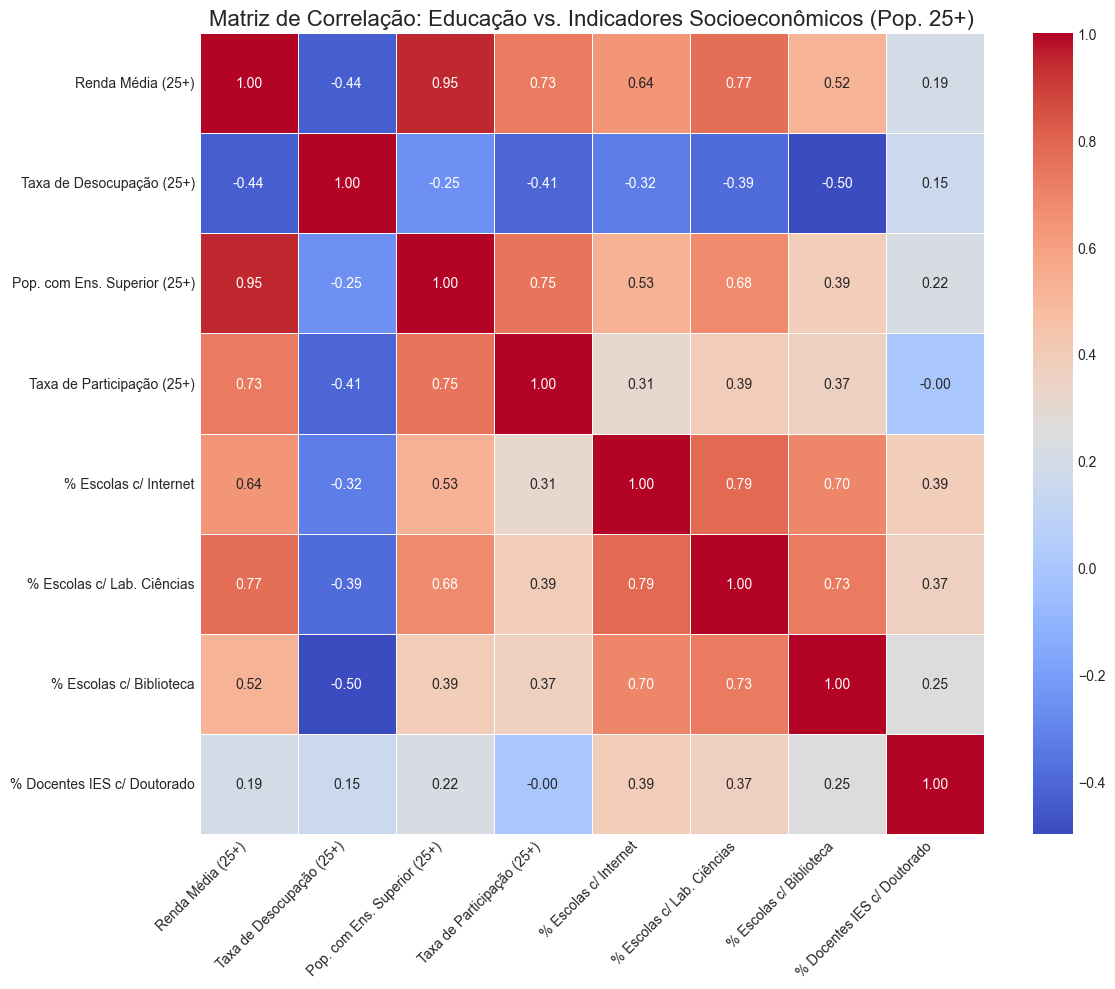

In [115]:



# --- Passo 2: Criar as Consultas SQL de Agregação por uf ---

# Query para a tabela de Escolas (Censo Escolar)
# Vamos calcular o percentual de escolas com internet e laboratório de ciências por uf
sql_escolas = """
SELECT
"sg_uf" AS uf,
AVG(CASE WHEN "in_internet" = 1 THEN 1 ELSE 0 END) AS perc_escolas_internet,
AVG(CASE WHEN "in_laboratorio_ciencias" = 1 THEN 1 ELSE 0 END) AS perc_escolas_lab_ciencias,
AVG(CASE WHEN "in_biblioteca" = 1 THEN 1 ELSE 0 END) AS perc_escolas_biblioteca
FROM
escolas
GROUP BY
"sg_uf";
"""

# Query para a tabela de IES (Censo Superior)
# Vamos somar a quantidade total de docentes e a quantidade com doutorado para calcular a proporção
sql_ies = """
SELECT
"sg_uf_ies" AS uf,
SUM("qt_doc_exe") AS total_docentes,
SUM("qt_doc_ex_dout") AS total_docentes_doutorado
FROM
ies
GROUP BY
"sg_uf_ies";
"""

# Query para a tabela da PNAD
# Vamos calcular a renda média, a taxa de desocupação e a proporção com ensino superior
# Assumindo códigos padrão da PNAD:
# renda_bruta_mensal: Renda mensal
# VD4002: 1=Ocupado, 2=Desocupado
# VD3001: Nível de instrução (ex: 6=Superior incompleto, 7=Superior completo)
sql_pnad_final = """
WITH pnad_agregada AS (
    -- CTE 1: Classifica cada indivíduo usando sua lógica exata
    WITH pnad_classificada AS (
        SELECT
            "uf",
            "idade",
            "curso_elevado_anterior",
            "renda_bruta_mensal",
            CASE
                WHEN "trab_remun_dinheiro"::text = '1' OR "trab_remun_prod_merc"::text = '1' OR "fez_bico_ocasional"::text = '1' OR "ajuda_trab_nao_remun"::text = '1' OR "afastado_trab_remun"::text = '1' THEN 'Ocupado'
                WHEN "procurou_trabalho"::text = '1' THEN 'Desocupado'
                WHEN "gostaria_trab_nao_procura"::text = '1' THEN 'Força de Trabalho Potencial'
                ELSE 'Fora da Força de Trabalho'
            END AS situacao_trabalho
        FROM pnad
        WHERE "idade" >= 14 -- A base populacional para mercado de trabalho é 14+
    )
    -- CTE 2: Agrega os dados por UF, usando agregação condicional para a população de 25+
    SELECT
        "uf" AS uf_codigo,

        -- Métrica 1: Renda média para 25+
        AVG(CASE WHEN "idade" >= 25 THEN "renda_bruta_mensal" END) AS renda_media,

        -- Métrica 2: Taxa de Desocupação (Desocupados / (Ocupados + Desocupados)) para 25+
        SUM(CASE WHEN "idade" >= 25 AND situacao_trabalho = 'Desocupado' THEN 1 ELSE 0 END)::FLOAT /
        NULLIF(SUM(CASE WHEN "idade" >= 25 AND situacao_trabalho IN ('Ocupado', 'Desocupado') THEN 1 ELSE 0 END)::FLOAT, 0) AS taxa_desocupacao,

        -- Métrica 3: Proporção com Ensino Superior para 25+
        AVG(CASE WHEN "idade" >= 25 AND "curso_elevado_anterior" IN ('12', '13', '14', '15') THEN 1 ELSE 0 END) AS prop_pop_ens_superior,
        
        -- Métrica 4 (NOVA): Taxa de Participação ((Ocupados + Desocupados) / População Total) para 25+
        SUM(CASE WHEN "idade" >= 25 AND situacao_trabalho IN ('Ocupado', 'Desocupado') THEN 1 ELSE 0 END)::FLOAT /
        NULLIF(SUM(CASE WHEN "idade" >= 25 THEN 1 ELSE 0 END)::FLOAT, 0) AS taxa_participacao

    FROM pnad_classificada
    GROUP BY "uf"
)
-- CTE Final: Converte o código da UF para a sigla
SELECT
    CASE uf_codigo
        WHEN '11' THEN 'RO' WHEN '12' THEN 'AC' WHEN '13' THEN 'AM' WHEN '14' THEN 'RR' WHEN '15' THEN 'PA'
        WHEN '16' THEN 'AP' WHEN '17' THEN 'TO' WHEN '21' THEN 'MA' WHEN '22' THEN 'PI' WHEN '23' THEN 'CE'
        WHEN '24' THEN 'RN' WHEN '25' THEN 'PB' WHEN '26' THEN 'PE' WHEN '27' THEN 'AL' WHEN '28' THEN 'SE'
        WHEN '29' THEN 'BA' WHEN '31' THEN 'MG' WHEN '32' THEN 'ES' WHEN '33' THEN 'RJ' WHEN '35' THEN 'SP'
        WHEN '41' THEN 'PR' WHEN '42' THEN 'SC' WHEN '43' THEN 'RS' WHEN '50' THEN 'MS' WHEN '51' THEN 'MT'
        WHEN '52' THEN 'GO' WHEN '53' THEN 'DF'
    END AS uf,
    renda_media,
    taxa_desocupacao,
    prop_pop_ens_superior,
    taxa_participacao
FROM pnad_agregada;
"""

# --- Passo 3: Executar as consultas e carregar em DataFrames ---
print("Executando consultas e carregando dados...")
df_escolas = pd.read_sql_query(sql_escolas, conn)
df_ies = pd.read_sql_query(sql_ies, conn)
df_pnad = pd.read_sql_query(sql_pnad_final, conn)

# Tratamento IES
df_ies['prop_docentes_doutorado'] = df_ies['total_docentes_doutorado'] / df_ies['total_docentes']
df_ies = df_ies[['uf', 'prop_docentes_doutorado']]

# --- Passo 4: Unir os DataFrames ---
print("\nUnindo os dataframes...")
df_final = pd.merge(df_pnad, df_escolas, on='uf', how='inner')
df_final = pd.merge(df_final, df_ies, on='uf', how='inner')
df_final.set_index('uf', inplace=True)

# Renomear colunas para o gráfico ficar mais legível
df_final.rename(columns={
    'renda_media': 'Renda Média (25+)',
    'taxa_desocupacao': 'Taxa de Desocupação (25+)',
    'prop_pop_ens_superior': 'Pop. com Ens. Superior (25+)',
    'taxa_participacao': 'Taxa de Participação (25+)',
    'perc_escolas_internet': '% Escolas c/ Internet',
    'perc_escolas_lab_ciencias': '% Escolas c/ Lab. Ciências',
    'perc_escolas_biblioteca': '% Escolas c/ Biblioteca',
    'prop_docentes_doutorado': '% Docentes IES c/ Doutorado'
}, inplace=True)

print("\nDataFrame final para análise:\n", df_final.head())

# --- Passo 5 e 6: Calcular e Visualizar a Matriz de Correlação ---
print("\nCalculando e gerando o heatmap da matriz de correlação...")
matriz_correlacao = df_final.corr()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax
)
ax.set_title('Matriz de Correlação: Educação vs. Indicadores Socioeconômicos (Pop. 25+)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()